IMPORTING LIBRARIES

In [24]:
from skimage.filters import gabor_kernel
from skimage import color
from scipy import ndimage as ndi
from scipy import signal
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from pathlib import Path
from skimage.io import imread, imshow
import random

In [10]:
df = pd.DataFrame()
datasetPath = Path('seg_train')
patharr = [ os.path.join(datasetPath, f) for f in os.listdir(datasetPath) if os.path.isdir(os.path.join(datasetPath, f))]
for dirpath in patharr:
    category = dirpath.split("\\")[1]
    df1 = pd.DataFrame()
    df1['image'] = [ os.path.join(dirpath, f) for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f))]
    df1['imgcategory'] = [ category for i in range(0, len(df1['image']))]
    df = df.append(df1)
    del df1
df.head()

,image,imgcategory
0,seg_train\buildings\0.jpg,buildings
1,seg_train\buildings\10006.jpg,buildings
2,seg_train\buildings\1001.jpg,buildings
3,seg_train\buildings\10014.jpg,buildings
4,seg_train\buildings\10018.jpg,buildings


In [11]:
theta = 4
frequency = (0.1, 0.5, 0.8)
sigma = (1, 3, 5)
bandwidth = (0.3, 0.7, 1)
n_slice = 2
h_type = 'global'
d_type = 'cosine'
depth = 1

In [12]:
def make_gabor_kernel(theta, frequency, sigma, bandwidth): 
    kernels = []
    for t in range(theta):
        t = t / float(theta) * np.pi
        for f in frequency:
            if sigma:
                for s in sigma:
                    kernel = gabor_kernel(f, theta=t, sigma_x=s, sigma_y=s)
                    kernels.append(kernel)
            if bandwidth:
                for b in bandwidth:
                    kernel = gabor_kernel(f, theta=t, bandwidth=b)
                    kernels.append(kernel)
    return kernels

gabor_kernels = make_gabor_kernel(theta, frequency, sigma, bandwidth)

In [13]:
def power(image, kernel):
    image = (image - image.mean()) / image.std()
    feats = np.zeros(2, dtype=np.double)
    f_img = np.sqrt(signal.fftconvolve(image, np.real(kernel), mode='same')**2 +
                   signal.fftconvolve(image, np.imag(kernel), mode='same')**2)
    feats[0] = f_img.mean()
    feats[1] = f_img.var()
    return feats

In [14]:
def gabor(img, kernels, normalize=True):
  results = []
  for kernel in kernels:
    results.append(power(img, kernel))
  hist = np.array([res for res in results])
  if normalize:
    hist = hist / np.sum(hist, axis=0)
  return hist.T.flatten()

In [17]:
def gabor_histogram(img, normalize=True):
  image = color.rgb2gray(img)
  hist = gabor(image, kernels=gabor_kernels)
  if normalize:
    hist /= np.sum(hist)

  return hist.flatten()

In [20]:
def getimagefeatures():
    database_features = np.empty([len(df['image']), 144])
    index = 0
    for imgpath in df['image']:
        image = imread(imgpath)
        image_features = gabor_histogram(image)
        database_features[index] = image_features
        index += 1
        if(index%1000 == 0):
            print(index);
    return database_features

imgfeatures = getimagefeatures();

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [21]:
numimages = 29
def match_image(randomimage, image_cat, mode='noshow'):
    if(mode=='show'):
        axes=[]
        fig=plt.figure(figsize=(8,8))
    query_features = gabor_histogram(randomimage)
    distancevector = np.empty([len(df['image'])])
    for i in range(0, len(df['image'])):
        image_features = imgfeatures[i]
        distancevector[i] = np.linalg.norm(image_features - query_features, axis=0)
    indexes = np.arange(distancevector.shape[0])
    dis_frame = pd.DataFrame({'Distance': distancevector, 'Index': indexes})
    dis_frame = dis_frame.reset_index(drop=True)
    dis_frame = dis_frame.sort_values('Distance', ascending=True)
    index = 0
    correct = 0
    for item in dis_frame.itertuples(index=True, name='Pandas'):
        if(index >= numimages):
            break
        img_index = item.Index
        if(df.iloc[img_index].imgcategory == image_cat):
            correct += 1
        if(index < 18 and mode=='show'):
            image = imread(df.iloc[item.Index].image)
            axes.append(fig.add_subplot(5, 6, index+1))
            plt.axis('off')
            plt.imshow(image)
        index+=1
    print('Accuracy with hsv_histogram and euclidian distance - ', (correct/numimages)*100, '%')
    if(mode=='show'):
        fig.tight_layout()
        plt.show()
    return (correct/numimages)*100

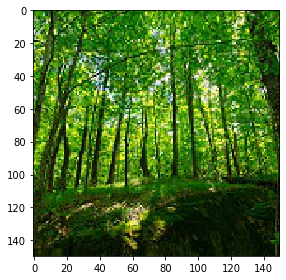

In [31]:
image_name = 'seg_train\\forest\\4739.jpg'
image_cat = 'forest'
image = imread(image_name)
imshow(image)

Accuracy with hsv_histogram and euclidian distance -  100.0 %


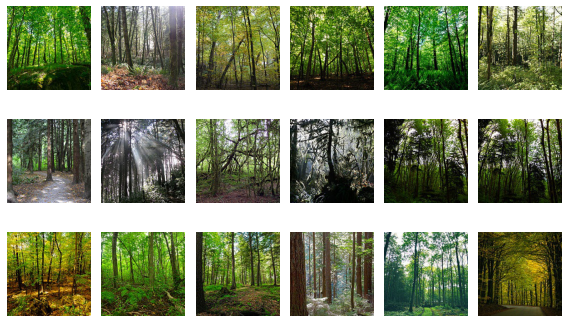

100.0

In [32]:
match_image(image, image_cat, mode='show')

In [37]:
img_count = 10
crr = 0
for i in range(0,img_count):
    randomIndex = random.randint(0, len(df))
    randomimage = df.iloc[randomIndex].image
    image = imread(randomimage)
    image_cat = df.iloc[randomIndex].imgcategory
    print(randomimage, image_cat)
    crr += match_image(image, image_cat)
print("Average accuracy for " + str(img_count) + " images is - " + str(crr/img_count) + " %")

seg_train\forest\19837.jpg forest
Accuracy with hsv_histogram and euclidian distance -  100.0 %
seg_train\street\19335.jpg street
Accuracy with hsv_histogram and euclidian distance -  58.620689655172406 %
seg_train\buildings\1445.jpg buildings
Accuracy with hsv_histogram and euclidian distance -  86.20689655172413 %
seg_train\mountain\2573.jpg mountain
Accuracy with hsv_histogram and euclidian distance -  86.20689655172413 %
seg_train\mountain\14866.jpg mountain
Accuracy with hsv_histogram and euclidian distance -  79.3103448275862 %
seg_train\street\8925.jpg street
Accuracy with hsv_histogram and euclidian distance -  37.93103448275862 %
seg_train\forest\8790.jpg forest
Accuracy with hsv_histogram and euclidian distance -  79.3103448275862 %
seg_train\mountain\17384.jpg mountain
Accuracy with hsv_histogram and euclidian distance -  31.03448275862069 %
seg_train\street\5182.jpg street
Accuracy with hsv_histogram and euclidian distance -  27.586206896551722 %
seg_train\mountain\9071.jpg